In [1]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import cbpro
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_62765/4123414874.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-21 11:51:07.969046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
USD = Asset('USD')
date_range = pd.date_range(start=tmpstemp.fromisoformat('2000-01-01'), end=tmpstemp.today())
idx =pd.DatetimeIndex(date_range, name = 'date_time')
USD_2000 = pd.DataFrame({'low':[1] * len(idx), 'high':[1] * len(idx),
                    'open':[1] * len(idx), 'close':[1] * len(idx),
                    'volume':[1000]* len(idx)},
                     index=idx)
USD.update_history(USD_2000)

In [3]:
with open('CoinBaseAPIKey.key', 'r') as f:
    contents = f.readlines()
cb_key = contents[0].split(':')[-1].strip()
cb_secret = contents[1].split(':')[-1].strip()

In [4]:
#Download data
public_client = cbpro.PublicClient()
slots = [('2023-01-01', '2023-06-01'), ('2022-07-01', '2022-12-31'), ('2022-01-01', '2022-06-30'), ('2023-06-02', '2023-12-01')]
BTC = Asset('BTC')
ETH = Asset('ETH')
USDT = Asset('USDT')

for slot in slots:
    BTC_USD = public_client.get_product_historic_rates('BTC-USD', slot[0], slot[1], 86400)
    ETH_USD = public_client.get_product_historic_rates('ETH-USD', slot[0], slot[1], 86400)
    USDT_USD = public_client.get_product_historic_rates('USDT-USD', slot[0], slot[1], 86400)
    btc_data= pd.DataFrame(BTC_USD)
    btc_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    btc_data['date_time']= btc_data['date_time'].apply(lambda x: tmpstemp.fromtimestamp(x))
    btc_data.set_index('date_time', inplace=True)
    BTC.update_history(btc_data)

    ETH_data= pd.DataFrame(ETH_USD)
    ETH_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    ETH_data['date_time']= ETH_data['date_time'].apply(lambda x: tmpstemp.fromtimestamp(x))
    ETH_data.set_index('date_time', inplace=True)
    ETH.update_history(ETH_data)

    USDT_data= pd.DataFrame(USDT_USD)
    USDT_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    USDT_data['date_time']= USDT_data['date_time'].apply(lambda x: tmpstemp.fromtimestamp(x))
    USDT_data.set_index('date_time', inplace=True)
    USDT.update_history(USDT_data)

In [5]:
my_portfolio = Portfolio(origination_date=tmpstemp.fromisoformat('2021-12-01'), initial_deposit=10000)
my_portfolio.update_transactions(ticker='BTC', qty=1, transaction_date=tmpstemp.fromisoformat('2022-01-01'))
my_portfolio.update_transactions(ticker='USDT', qty=40000, transaction_date=tmpstemp.fromisoformat('2022-01-01'))

In [6]:
class Strategy:

    def __init__(self):
        self.frequency = 1
        self.model = Model()
        self.input_span = 15

    def suggest_decision(self, portfolio: Portfolio):
        '''
        Returns a datframe with the suggested updates to portfolio
        '''
        delta_df = pd.DataFrame()
        return delta_df

    def backtest(self, hist_data: pd.DataFrame, portfolio: Portfolio):
        updated_portfolio = Portfolio()
        return updated_portfolio
    
    def train_val_split_scale(df, scaler, input_span):
        len_train = int(0.7*len(df))
        print(f'len_train {len_train}')
        len_test = len(df) - len_train
        last_date_train = df.index[len_train]
        first_date_val = df.index[len_train+1]
        X = []
        y = []
        scaled_data = scaler.fit_transform(np.array(df['close'].values).reshape(-1,1) )
        for x in range(input_span, len(df)):
            X.append(scaled_data[x-input_span:x, 0])
            y.append(scaled_data[x,0])
        X, y = (np.array(X), np.array(y))
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        print(X.shape)
        print(y.shape)
        train_idx = df.index[input_span:len_train]
        val_index = df.index[len_train:]
        print(f'from {train_idx[0]} to {train_idx[-1]}')
        return X[0:len_train-input_span,:,:], y[0:len_train-input_span], train_idx, X[len_train-input_span:,:,:], y[len_train-input_span:], val_index

    def make_model():
        return self.model


In [7]:
naive_LSTM = Strategy()

In [8]:
input_span = 15
scaler  = MinMaxScaler(feature_range=(0,1))
x_train, y_train, train_idx, x_val, y_val, val_idx = naive_LSTM.train_val_split_scale(BTC.history, scaler, input_span)

len_train 489
(685, 15, 1)
(685,)
from 2022-01-15 19:00:00 to 2023-05-03 20:00:00


In [9]:
hidden_size = 50
dropout = 0.2
learning_rate = 0.001

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]), name = 'input')

LSTM1 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM1' )(input_layer)
LSTM1 = Dropout(dropout)(LSTM1)

LSTM2 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM2' )(LSTM1)
LSTM2 = Dropout(dropout)(LSTM2)

LSTM3 = LSTM(units = 50, activation='tanh', name = 'LSTM3' )(LSTM2)
LSTM3 = Dropout(dropout)(LSTM3)
'''
hidden1 = Dense(hidden_size, activation='relu', name='hidden_layer1')(LSTM3)
hidden1 = Dropout(dropout)(hidden1)
'''

# Create output layer
out = Dense(1, activation='linear', name = 'Regression_layer')(LSTM3)
model = Model(inputs=[input_layer], outputs=out)


model.compile(optimizer=Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])
naive_LSTM.model = model
naive_LSTM.model.summary()

2024-04-21 11:51:15.732788: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-04-21 11:51:16.481934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 11:51:16.485720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 11:51:16.4

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 1)]           0         
                                                                 
 LSTM1 (LSTM)                (None, 15, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 15, 50)            0         
                                                                 
 LSTM2 (LSTM)                (None, 15, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 15, 50)            0         
                                                                 
 LSTM3 (LSTM)                (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0     

2024-04-21 11:51:18.009743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 11:51:18.015176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 11:51:18.019512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

model.fit([x_train], y_train, 
          validation_data=([x_val], y_val),
          epochs=20, batch_size=8,
          callbacks=[early_stopping])


Epoch 1/20


2024-04-21 11:51:19.251845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 11:51:19.257984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 11:51:19.262154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

60/60 [==============================] - ETA: 0s - loss: 0.0262 - mean_squared_error: 0.0262

2024-04-21 11:51:47.046004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 11:51:47.050373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 11:51:47.054450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

60/60 [==============================] - 36s 317ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 2/20
60/60 [==============================] - 14s 239ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 3/20
60/60 [==============================] - 12s 208ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/20
60/60 [==============================] - 13s 219ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 5/20
60/60 [==============================] - 12s 194ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 6/20
60/60 [==============================] - 13s 217ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 7/20
60/60 [===============

In [11]:
predicted = {}
current = {}

# Given the new data go one time point after another and make predictions 
for x in range(1,len(val_idx)):
    model_input = x_val[x,:,:].reshape(1,input_span,1)                       # Data shaped as input for the model
    pred_BTC_price = model.predict(model_input, verbose=0)                                # Predict
    pred_BTC_price = scaler.inverse_transform(pred_BTC_price)[0][0]                        # Un-scale to get predicted asset price

    # Format string for output
    current_date = val_idx[x-1]
    predicted_for_date = val_idx[x]                   # Get date we are predictig for 
    curr_BTC_price = BTC.history['close'].loc[current_date]                                             # Get current asset price 
    #print(f'Today ({val_idx[x]}):{curr_BTC_price}, predicted for {predicted_for_date}: {pred_BTC_price}')
    predicted[predicted_for_date] = pred_BTC_price
    current[current_date] = curr_BTC_price                                               # Save the result in the output array
predicted_df = pd.DataFrame(columns = ['predicted'], data = predicted.values(), index = pd.DatetimeIndex(predicted.keys(), name = 'date_time'))
current_df = pd.DataFrame(columns = ['current'], data = current.values(), index = pd.DatetimeIndex(current.keys(), name = 'date_time'))
df_to_plot = pd.merge(current_df, predicted_df, left_index=True, right_index=True)
df_to_plot.head()

2024-04-21 11:55:55.519349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 11:55:55.524178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 11:55:55.527771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

,current,predicted
date_time,,
2023-05-05 20:00:00,28902.66,29251.804688
2023-05-06 20:00:00,28474.53,29293.876953
2023-05-07 20:00:00,27695.06,29304.843750
2023-05-08 20:00:00,27647.29,29249.880859
2023-05-09 20:00:00,27624.01,29133.023438


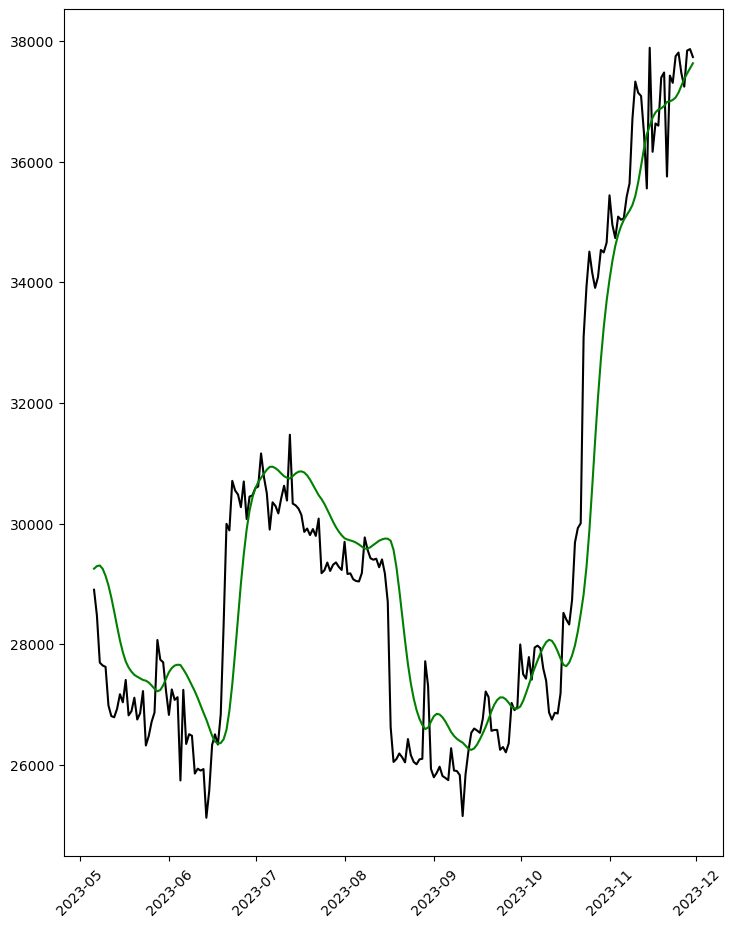

In [12]:
# Plot the results
fig, ax = plt.subplots(1, 1, sharex = True)
fig.set_figheight(11)
fig.set_figwidth(8.5)
ax.plot(df_to_plot.index, df_to_plot['current'], color = 'black', label = 'Actual')
ax.plot(df_to_plot.index, df_to_plot['predicted'], color = 'green', label = 'Predicted')
for tick in ax.get_xticklabels():
        tick.set_rotation(45)